Copyright (c) Microsoft Corporation.

Licensed under the MIT License.

# Model training and evaluation on F3 Netherlands dataset

Seismic interpretation, also referred to as facies classification, is a task of determining types of rock in the earth’s subsurface, given seismic data. Seismic interpretation is used as a standard approach for determining precise locations of oil deposits for drilling, therefore reducing risks and potential losses. In recent years, there has been a great interest in using fully-supervised deep learning models for seismic interpretation. 

In this notebook, we demonstrate how to train a deep neural network for facies prediction using F3 Netherlands dataset. The F3 block is located in the North Sea off the shores of Netherlands. The dataset contains 6 classes (facies or lithostratigraphic units), all of which are of varying thickness (class imbalance). Processed data is available in numpy format as a `401 x 701 x 255` array. The processed F3 data is made available by [Alaudah et al. 2019](https://github.com/olivesgatech/facies_classification_benchmark). 

## Environment setup

To set up the conda environment, please follow the instructions in the top-level [README.md](../../../README.md) file.

__Note__: To register the conda environment in Jupyter, run:
`python -m ipykernel install --user --name envname`

## Library imports

Let's load required libraries.

In [1]:
import logging
import logging.config
from os import path
import random
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})

import yacs.config

import cv2
import numpy as np
import torch
from albumentations import Compose, HorizontalFlip, Normalize, PadIfNeeded, Resize
from ignite.contrib.handlers import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from ignite.engine import Events
from ignite.metrics import Loss
from ignite.utils import convert_tensor
from toolz import compose, take
from torch.utils import data

from cv_lib.utils import load_log_configuration
from cv_lib.event_handlers import SnapshotHandler, logging_handlers
from cv_lib.segmentation import models
from cv_lib.segmentation.dutchf3.engine import create_supervised_trainer

from cv_lib.segmentation.dutchf3.utils import (
    current_datetime,
    generate_path,
    git_branch,
    git_hash,
    np_to_tb,
)

from deepseismic_interpretation.dutchf3.data import (
    get_patch_loader,
    decode_segmap,
    get_test_loader,
)

from itkwidgets import view

from utilities import (
    plot_aline,
    prepare_batch,
    patch_label_2d,
    compose_processing_pipeline,
    output_processing_pipeline,
    write_section_file,
    runningScore,
)

# set device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# number of images to score
N_EVALUATE = 20
# experiment configuration file
CONFIG_FILE = "./configs/patch_deconvnet_skip.yaml"


## Data download and preparation

To download and prepare the F3 data set, please follow the instructions in the top-level [README](../../../README.md) file. Once you've downloaded and prepared the data set, you'll find your files in the following directory tree:

```
data
├── splits
├── test_once
│   ├── test1_labels.npy
│   ├── test1_seismic.npy
│   ├── test2_labels.npy
│   └── test2_seismic.npy
└── train
    ├── train_labels.npy
    └── train_seismic.npy
```

We recommend saving the data under `$HOME/data/dutchf3` since this notebook will use that location as the data root. Otherwise, modify the `DATASET.ROOT` field in the configuration file, described next. 

## Experiment configuration file

We use configuration files to specify experiment configuration, such as hyperparameters used in training and evaluation, as well as other experiment settings. We provide several configuration files for this notebook, under `./configs`, mainly differing in the DNN architecture used for defining the model.

Modify the `CONFIG_FILE` variable above if you would like to run the experiment using a different configuration file.

In [2]:
with open(CONFIG_FILE, "rt") as f_read:
    config = yacs.config.load_cfg(f_read)

print(f'Configuration loaded. Please check that the DATASET.ROOT:{config.DATASET.ROOT} points to your data location.')
print(f'To modify any of the options, please edit the configuration file {CONFIG_FILE} and reload. \n')
print(config)

Configuration loaded. Please check that the DATASET.ROOT:/data/dutchf3 points to your data location.
To modify any of the options, please edit the configuration file ./configs/patch_deconvnet_skip.yaml and reload. 

CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  CLASS_WEIGHTS: [0.7151, 0.8811, 0.5156, 0.9346, 0.9683, 0.9852]
  NUM_CLASSES: 6
  ROOT: /data/dutchf3
GPUS: (0,)
LOG_CONFIG: logging.conf
LOG_DIR: log
MODEL:
  IN_CHANNELS: 1
  NAME: patch_deconvnet_skip
OUTPUT_DIR: output
PRINT_FREQ: 50
SEED: 2019
TEST:
  CROSSLINE: True
  INLINE: True
  MODEL_PATH: /data/home/mat/repos/DeepSeismic/examples/interpretation/notebooks/output/models/model_patch_deconvnet_skip_2.pth
  POST_PROCESSING:
    CROP_PIXELS: 0
    SIZE: 99
  SPLIT: test1
  TEST_STRIDE: 10
TRAIN:
  AUGMENTATION: True
  AUGMENTATIONS:
    PAD:
      HEIGHT: 99
      WIDTH: 99
    RESIZE:
      HEIGHT: 99
      WIDTH: 99
  BATCH_SIZE_PER_GPU: 64
  BEGIN_EPOCH: 0
  DEPTH: none
  END_EPOCH: 100
  M

Override parameters in case we use papermill

In [3]:
# The number of datapoints you want to run in training or validation per batch 
# Setting to None will run whole dataset
# useful for integration tests with a setting of something like 3
# Use only if you want to check things are running and don't want to run
# through whole dataset
max_iterations = None
# The number of epochs to run in training
max_epochs = config.TRAIN.END_EPOCH  
max_snapshots = config.TRAIN.SNAPSHOTS
dataset_root = config.DATASET.ROOT

In [4]:
# reduce number of test images if running a dummy model
if max_epochs<2:
    N_EVALUATE=3

## F3 data set 

Let's visualize a few sections of the F3 data set. The processed F3 data set is stored as a 3D numpy array. Let's view slices of the data along inline and crossline directions. 

In [5]:
# Load training data and labels
train_seismic = np.load(path.join(dataset_root, "train/train_seismic.npy"))
train_labels = np.load(path.join(dataset_root, "train/train_labels.npy"))

print(f"Number of inline slices: {train_seismic.shape[0]}")
print(f"Number of crossline slices: {train_seismic.shape[1]}")
print(f"Depth dimension : {train_seismic.shape[2]}")

Number of inline slices: 401
Number of crossline slices: 701
Depth dimension : 255


In [6]:
view(train_labels, slicing_planes=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

Let's plot an __inline__ slice.

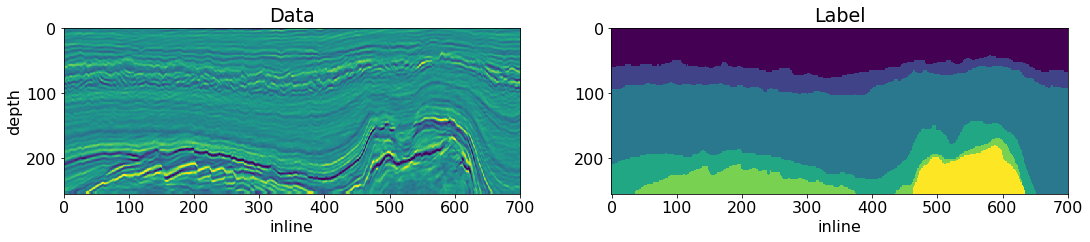

In [7]:
idx = 100
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

plot_aline(x_in, x_inl, xlabel="inline")

Let's plot a __crossline__ slice.

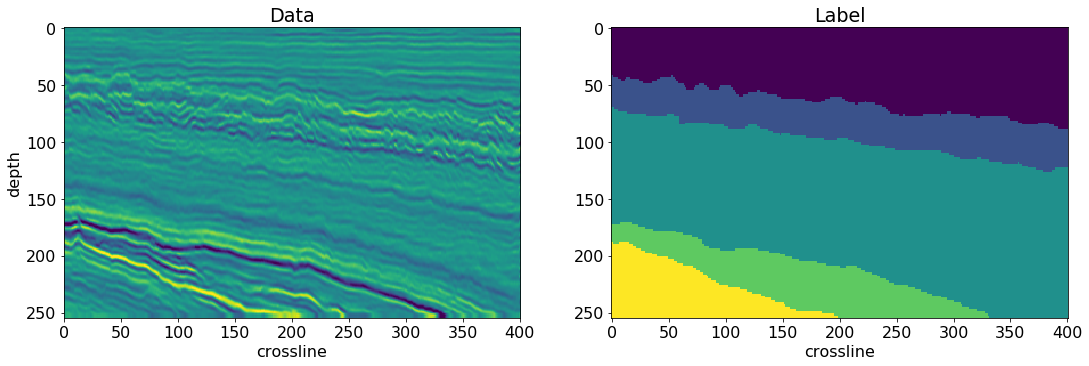

In [8]:
x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

plot_aline(x_cr, x_crl, xlabel="crossline")

## Model training

In [9]:
# Set up logging
load_log_configuration(config.LOG_CONFIG)
logger = logging.getLogger(__name__)
logger.debug(config.WORKERS)
torch.backends.cudnn.benchmark = config.CUDNN.BENCHMARK


2019-12-09 04:08:24,354 - cv_lib.utils - INFO - logging.conf configuration file was loaded.


### Set up data augmentation

Let's define our data augmentation pipeline, which includes basic transformations, such as _data normalization, resizing, and padding_ if necessary. 

In [10]:
# Setup Augmentations
basic_aug = Compose(
    [
        Normalize(
            mean=(config.TRAIN.MEAN,), std=(config.TRAIN.STD,), max_pixel_value=1
        ),
        Resize(
            config.TRAIN.AUGMENTATIONS.RESIZE.HEIGHT,
            config.TRAIN.AUGMENTATIONS.RESIZE.WIDTH,
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=config.TRAIN.AUGMENTATIONS.PAD.HEIGHT,
            min_width=config.TRAIN.AUGMENTATIONS.PAD.WIDTH,
            border_mode=cv2.BORDER_CONSTANT,
            always_apply=True,
            mask_value=255,
        ),
    ]
)

if config.TRAIN.AUGMENTATION:
    train_aug = Compose([basic_aug, HorizontalFlip(p=0.5)])
else:
    train_aug = basic_aug

### Load the data

For training the model, we will use a patch-based approach. Rather than using entire sections (crosslines or inlines) of the data, we extract a large number of small patches from the sections, and use the patches as our data. This allows us to generate larger set of images for training, but is also a more feasible approach for large seismic volumes. 

We are using a custom patch data loader from our __`deepseismic_interpretation`__ library for generating and loading patches from seismic section data.

In [11]:
TrainPatchLoader = get_patch_loader(config)

train_set = TrainPatchLoader(
    dataset_root,
    split="train",
    is_transform=True,
    stride=config.TRAIN.STRIDE,
    patch_size=config.TRAIN.PATCH_SIZE,
    augmentations=train_aug,
)


train_loader = data.DataLoader(
    train_set,
    batch_size=config.TRAIN.BATCH_SIZE_PER_GPU,
    num_workers=config.WORKERS,
    shuffle=True,
)


This no longer pads the volume


### Set up model training

Next, let's define a model to train, an optimization algorithm, and a loss function. 

Note that the model is loaded from our __`cv_lib`__ library, using the name of the model as specified in the configuration file. To load a different model, either change the `MODEL.NAME` field in the configuration file, or create a new one corresponding to the model you wish to train.

In [12]:
# load a model
model = getattr(models, config.MODEL.NAME).get_seg_model(config)

# Send to GPU if available
model = model.to(device)

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=config.TRAIN.MAX_LR,
    momentum=config.TRAIN.MOMENTUM,
    weight_decay=config.TRAIN.WEIGHT_DECAY,
)

# learning rate scheduler
scheduler_step = max_epochs // max_snapshots
snapshot_duration = scheduler_step * len(train_loader)
scheduler = CosineAnnealingScheduler(
    optimizer, "lr", config.TRAIN.MAX_LR, config.TRAIN.MIN_LR, snapshot_duration
)

# weights are inversely proportional to the frequency of the classes in the training set
class_weights = torch.tensor(
    config.DATASET.CLASS_WEIGHTS, device=device, requires_grad=False
)

# loss function
criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights, ignore_index=255, reduction="mean"
)

### Training the model

We use [ignite](https://pytorch.org/ignite/index.html) framework to create training and validation loops in our codebase. Ignite provides an easy way to create compact training/validation loops without too much boilerplate code.

In this notebook, we demonstrate the use of ignite on the training loop only. We create a training engine `trainer` that loops multiple times over the training dataset and updates model parameters. In addition, we add various events to the trainer, using an event system, that allows us to interact with the engine on each step of the run, such as, when the trainer is started/completed, when the epoch is started/completed and so on. 

In the cell below, we use event handlers to add the following events to the training loop:
- log training output
- log and schedule learning rate and
- periodically save model to disk.

In [13]:
# create training engine
trainer = create_supervised_trainer(
    model, optimizer, criterion, prepare_batch, device=device
)

# add learning rate scheduler
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

# add logging of traininig output
trainer.add_event_handler(
    Events.ITERATION_COMPLETED,
    logging_handlers.log_training_output(log_interval=config.PRINT_FREQ),
)

# add logging of learning rate
trainer.add_event_handler(Events.EPOCH_STARTED, logging_handlers.log_lr(optimizer))

# add model checkpointing
output_dir = path.join(config.OUTPUT_DIR, config.TRAIN.MODEL_DIR)
checkpoint_handler = ModelCheckpoint(
    output_dir, "model", save_interval=1, n_saved=10, create_dir=True, require_empty=False
)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED, checkpoint_handler, {config.MODEL.NAME: model}
)

Limit the number of datapoints if we happen to be in test mode

In [14]:
if max_iterations is not None:    
    train_loader = take(max_iterations, train_loader)

Start the training engine run.

In [15]:
trainer.run(train_loader, max_epochs=max_epochs)

2019-12-09 04:08:27,209 - ignite.engine.engine.Engine - INFO - Engine run starting with max_epochs=1.
2019-12-09 04:08:27,211 - cv_lib.event_handlers.logging_handlers - INFO - lr - [0.02]
2019-12-09 04:08:31,265 - ignite.engine.engine.Engine - INFO - Epoch[1] Complete. Time taken: 00:00:04
2019-12-09 04:08:32,319 - ignite.engine.engine.Engine - INFO - Engine run complete. Time taken 00:00:05


State:
	output: <class 'dict'>
	batch: <class 'list'>
	dataloader: <class 'itertools.islice'>
	max_epochs: 1
	metrics: <class 'dict'>
	iteration: 3
	epoch: 1

## Evaluation

We will next evaluate the performance of the model by looking at how well it predicts facies labels on samples from the test set.

We will use the following evaluation metrics:

- Pixel Accuracy (PA)
- Class Accuracy (CA)
- Mean Class Accuracy (MCA)
- Frequency Weighted intersection-over-union (FW IoU)
- Mean IoU (MIoU)

Let's first load the model saved previously.

In [16]:
with open(CONFIG_FILE, "rt") as f_read:
    config = yacs.config.load_cfg(f_read)

In [17]:
model = getattr(models, config.MODEL.NAME).get_seg_model(config)
if max_epochs>1:    
    model.load_state_dict(torch.load(config.TEST.MODEL_PATH), strict=False)
else:
    model.load_state_dict(torch.load(path.join(output_dir, "model_patch_deconvnet_skip_1.pth")), strict=False)
model = model.to(device)

Next we load the test data and define the augmentations on it. 

In [18]:
# Augmentation
section_aug = Compose(
    [Normalize(mean=(config.TRAIN.MEAN,), std=(config.TRAIN.STD,), max_pixel_value=1)]
)

patch_aug = Compose(
    [
        Resize(
            config.TRAIN.AUGMENTATIONS.RESIZE.HEIGHT,
            config.TRAIN.AUGMENTATIONS.RESIZE.WIDTH,
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=config.TRAIN.AUGMENTATIONS.PAD.HEIGHT,
            min_width=config.TRAIN.AUGMENTATIONS.PAD.WIDTH,
            border_mode=cv2.BORDER_CONSTANT,
            always_apply=True,
            mask_value=255,
        ),
    ]
)

# Process test data
pre_processing = compose_processing_pipeline(config.TRAIN.DEPTH, aug=patch_aug)
output_processing = output_processing_pipeline(config)

# Select the test split
split = "test1" if "both" in config.TEST.SPLIT else config.TEST.SPLIT

labels = np.load(path.join(dataset_root, "test_once", split + "_labels.npy"))
section_file = path.join(dataset_root, "splits", "section_" + split + ".txt")
write_section_file(labels, section_file, config)

# Load test data
TestSectionLoader = get_test_loader(config)
test_set = TestSectionLoader(
    dataset_root, split=split, is_transform=True, augmentations=section_aug
)
# needed to fix this bug in pytorch https://github.com/pytorch/pytorch/issues/973
# one of the workers will quit prematurely
torch.multiprocessing.set_sharing_strategy('file_system')
test_loader = data.DataLoader(
    test_set, batch_size=1, num_workers=config.WORKERS, shuffle=False
)


### Predict segmentation mask on the test data

For demonstration purposes and efficiency, we will only use a subset of the test data to predict segmentation mask on. More precisely, we will score `N_EVALUATE` images. If you would like to evaluate more images, set this variable to the desired number of images.

In [19]:
CLASS_NAMES = [
    "upper_ns",
    "middle_ns",
    "lower_ns",
    "rijnland_chalk",
    "scruff",
    "zechstein",
]

n_classes = len(CLASS_NAMES)

# keep only N_EVALUATE sections to score
test_subset = random.sample(list(test_loader), N_EVALUATE)

results = list()
running_metrics_split = runningScore(n_classes)

# testing mode
with torch.no_grad():
    model.eval()
    # loop over testing data
    for i, (images, labels) in enumerate(test_subset):
        logger.info(f"split: {split}, section: {i}")
        outputs = patch_label_2d(
            model,
            images,
            pre_processing,
            output_processing,
            config.TRAIN.PATCH_SIZE,
            config.TEST.TEST_STRIDE,
            config.VALIDATION.BATCH_SIZE_PER_GPU,
            device,
            n_classes,
        )

        pred = outputs.detach().max(1)[1].numpy()
        gt = labels.numpy()
        
        # update evaluation metrics
        running_metrics_split.update(gt, pred)
        
        # keep ground truth and result for plotting
        results.append((np.squeeze(gt), np.squeeze(pred)))
        

2019-12-09 04:08:36,547 - __main__ - INFO - split: test1, section: 0
2019-12-09 04:08:41,543 - __main__ - INFO - split: test1, section: 1
2019-12-09 04:08:42,067 - __main__ - INFO - split: test1, section: 2


Let's view the obtained metrics on this subset of test images. Note that we trained our model for for a small number of epochs, for demonstration purposes, so the performance results here are not meant to be representative. 

The performance exceed the ones shown here when the models are trained properly. For the full report on benchmarking performance results, please refer to the [README.md](../../../README.md) file.

In [20]:
# get scores
score, _ = running_metrics_split.get_scores()

# Log split results
print(f'Pixel Acc: {score["Pixel Acc: "]:.3f}')
for cdx, class_name in enumerate(CLASS_NAMES):
    print(f'  {class_name}_accuracy {score["Class Accuracy: "][cdx]:.3f}')

print(f'Mean Class Acc: {score["Mean Class Acc: "]:.3f}')
print(f'Freq Weighted IoU: {score["Freq Weighted IoU: "]:.3f}')
print(f'Mean IoU: {score["Mean IoU: "]:0.3f}')

Pixel Acc: 0.522
  upper_ns_accuracy 0.000
  middle_ns_accuracy 0.000
  lower_ns_accuracy 0.999
  rijnland_chalk_accuracy 0.000
  scruff_accuracy 0.001
  zechstein_accuracy nan
Mean Class Acc: 0.200
Freq Weighted IoU: 0.273
Mean IoU: 0.105


invalid value encountered in true_divide
invalid value encountered in true_divide


### Visualize predictions

Let's visualize the predictions on entire test sections. Note that the crosslines and inlines have different dimensions, however we were able to use them jointly for our network training and evaluation, since we were using smaller patches from the sections, whose size we can control via hyperparameter in the experiment configuration file. 

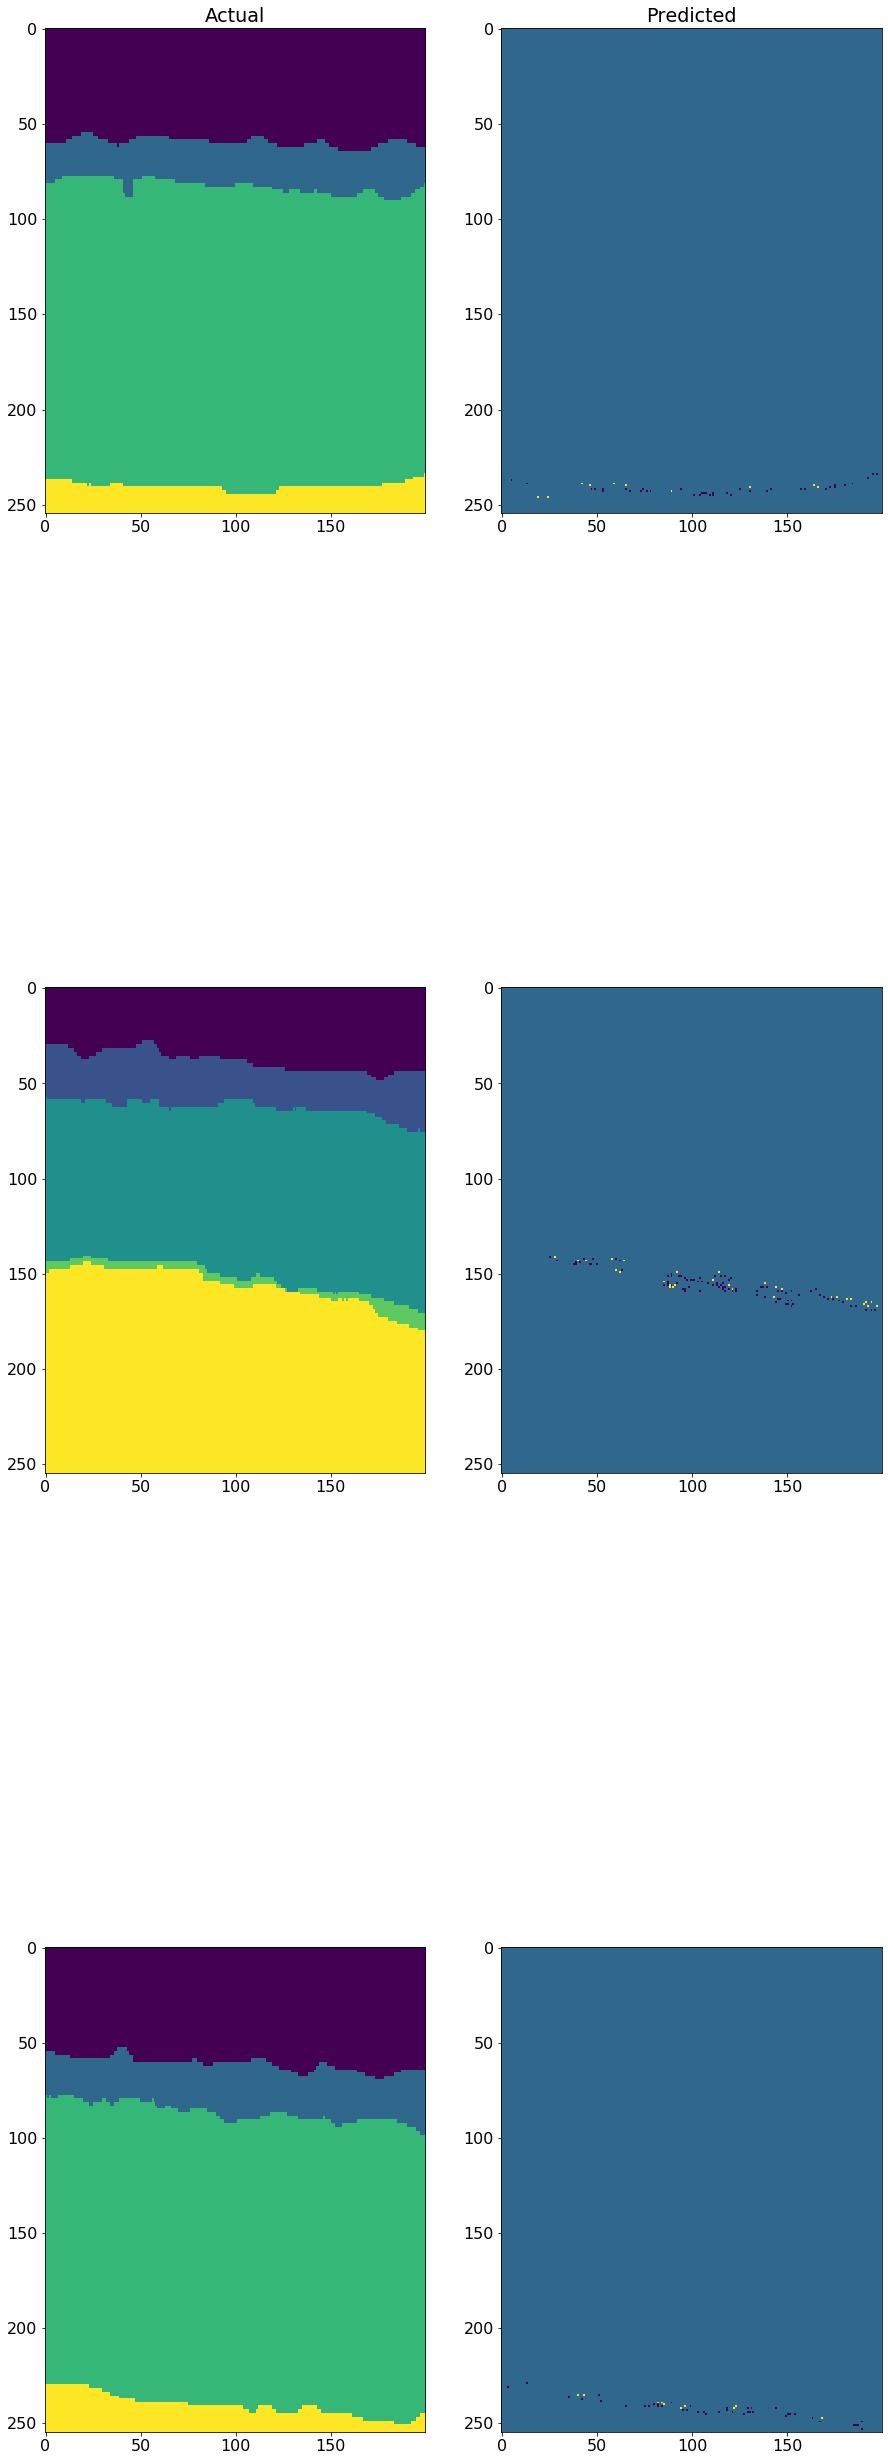

In [21]:
fig = plt.figure(figsize=(15,50))

nplot = min(N_EVALUATE, 10)
for idx in range(nplot):
    # plot actual
    plt.subplot(nplot, 2, 2*(idx+1)-1)
    plt.imshow(results[idx][0])
    # plot predicted
    plt.subplot(nplot, 2, 2*(idx+1))
    plt.imshow(results[idx][1])

f_axes = fig.axes
_ = f_axes[0].set_title('Actual')
_ = f_axes[1].set_title('Predicted')    